In [2]:
import pandas as pd 
import scipy.stats as sp
import numpy as np 

In [3]:
df_planning =pd.read_excel('omloopplanning.xlsx')
df = pd.read_excel('Connexxion data - 2024-2025.xlsx')
df_tijden = pd.read_excel('Connexxion data - 2024-2025 - kopie.xlsx')


Check beginttijd > Eindtijd
Hier zou je via streamlit een output van kunnen maken dat hij dit weer geeft. Dan zouden we alleen nog wat moeten verzinnen op het feit voor twaalf begonnen en na twaalf terug.

In [4]:
df_planning['starttijd'] = pd.to_datetime(df_planning['starttijd'], format='%H:%M:%S')
df_planning['eindtijd'] = pd.to_datetime(df_planning['eindtijd'], format='%H:%M:%S')
check = df_planning[df_planning['starttijd']> df_planning['eindtijd']]
altijd_correct = check.all()
check



,Unnamed: 0,startlocatie,eindlocatie,starttijd,eindtijd,activiteit,buslijn,energieverbruik,starttijd datum,eindtijd datum,omloop nummer
59,59,ehvbst,ehvapt,1900-01-01 23:37:00,1900-01-01 00:01:00,dienst rit,401.0,10.8036,2024-08-29 23:37:00,2024-08-30 00:01:00,1
122,122,ehvapt,ehvbst,1900-01-01 23:35:00,1900-01-01 00:00:00,dienst rit,401.0,10.8600,2024-08-29 23:35:00,2024-08-30 00:00:00,2


Check of tussen de min en max tijd ligt

In [5]:
df_tijden['min_reistijd_in_min'] = pd.to_timedelta(df_tijden['min reistijd in min'], unit='m')
df_tijden['max_reistijd_in_min'] = pd.to_timedelta(df_tijden['max reistijd in min'], unit='m')

# Stap 2: Merge df_planning en df_tijden op basis van een gemeenschappelijke kolom, zoals 'reis_id'
df_merged = pd.merge(df_planning, df_tijden, on='buslijn')

# Stap 3: Bereken het tijdsverschil tussen eindtijd en begintijd in minuten
df_merged['verschil_in_min'] = (df_merged['eindtijd'] - df_merged['starttijd']).dt.total_seconds() / 60

# Stap 4: Controleer of het verschil in minuten tussen de minimale en maximale reistijd ligt
df_merged['correct'] = (df_merged['verschil_in_min'] >= df_merged['min_reistijd_in_min'].dt.total_seconds() / 60) & \
                       (df_merged['verschil_in_min'] <= df_merged['max_reistijd_in_min'].dt.total_seconds() / 60)

# Filter de rijen waar de activiteit niet gelijk is aan 'dienst rit' of 'materiaal rit'
df_merged_filtered = df_merged[~df_merged['activiteit'].isin(['dienst rit', 'materiaal rit','opladen'])]

# Controleer of alle overgebleven rijen correct zijn
altijd_correct = df_merged_filtered['correct'].all()

df_fouten = df_merged[
    (df_merged['correct'] == False) & 
    (~df_merged['activiteit'].isin(['dienst rit', 'materiaal rit', 'dle','opladen']))
]

# Resultaat weergeven
if altijd_correct:
    print("Alle reistijden zijn binnen het correcte bereik (zonder dienst rit, materiaal rit, idle en opladen).")
else:
    print("Er zijn reistijden die buiten het correcte bereik vallen (zonder 'dienst rit' en 'materiaal rit').")
    df_fouten

 





Er zijn reistijden die buiten het correcte bereik vallen (zonder 'dienst rit' en 'materiaal rit').


In [6]:
min_tijd = pd.to_datetime(df_tijden["min reistijd in min"], format = "%M")
max_tijd = pd.to_datetime(df_tijden["max reistijd in min"], format = "%M")
df_planning["eindtijd"]-df_planning["begintijd"]
check = df_planning[df_planning['starttijd']> df_planning['eindtijd']]
altijd_correct = check.all()
check = df_planning

KeyError: 'begintijd'

Bus per omloop energieverbruik boven 364.5


In [23]:
# hier loop van maken voor elke omloop nummer = i en dan i elke data set etc
# maak extra lijst per omloopsplanning dit checken en dat toevoegen in dict 
df8  = df_planning[df_planning['omloop nummer'] ==8]

df8 = df8.sort_values(by='starttijd')

poepkont = df8['energieverbruik']

k = []
for i in poepkont:
    k.append(i)
    b = sum(k)
    if b >= 364.5:
        print(f" {b} loser")
        

De maximale energieverbruik is 364.5 voordat ze bij de garage moeten zijn. Hier onder is een overzicht van hoeveel energie een bus maximaal heeft verbruikt voordat hij is gaan opladen. 

In [24]:
max_b_per_omloop = {}

# Loop over alle unieke omloop nummers in de DataFrame
for omloop_nummer in df_planning['omloop nummer'].unique():
    # Filteren op huidige omloop nummer
    df_omloop = df_planning[df_planning['omloop nummer'] == omloop_nummer]
    
    # Sorteren op 'starttijd'
    df_omloop = df_omloop.sort_values(by='starttijd')
    
    # Lijst van energieverbruik per omloop nummer
    energieverbruik = df_omloop['energieverbruik']
     
    k = []
    max_b = 0
    for i in energieverbruik:
        k.append(i)
        b = sum(k)
        
        # Update max_b als de nieuwe som van 'b' groter is
        if b > max_b:
            max_b = b
        
        # Breek als b >= 364.5, maar we willen nog steeds max_b opslaan
        if b >= 364.5:
            print(f"{b} loser voor omloop nummer {omloop_nummer}")
            break

    # Opslaan van het maximale b voor de huidige omloop nummer
    max_b_per_omloop[omloop_nummer] = max_b

# Het resultaat: Dictionary met maximale b per omloop nummer
sorted_dict = pd.DataFrame(sorted(max_b_per_omloop.items()))

# Geordende dictionary printen
sorted_dict

,0,1
0,1,253.3368
1,2,263.6468
2,3,264.1364
3,4,242.5328
4,5,240.9904
5,6,232.6996
6,7,232.6996
7,8,235.3904
8,9,236.2248
9,10,236.7284


Uit de informatie hier boven kunnen we halen dat de omlopen verbeterd kunnen worden en er minder kunnen zijn en hiermee dan kosten zullen besparen. De enige vraag is hoe gaan we de omloop met python aanpassen. Mis eerst handmatig proberen kijken hoe we dit doen en dit in python schrijven. Als je het optimaal wilt doen krijg je waarschijnlijk het probleem dat er geen ondergrens is voor hoeveel bussen waar rijden met combinatie omdat er geen passagiers zijn. Je kan mis wel constraint dat er even vaak langs elk bus station in de huidige volgorde en vertrek tijden gaat zijn. opletten dat de max tijd niet wordt overschreden. Dus eigenlijk de checks hier boven weer uitvoeren

omloop vergelijken start en eind tijd ritten, kijken bij elke omloop of niet overeenkomt zodat je tussen kan pakken. en dan verbruik checekb 

In [7]:

billen = sorted_dict[1]
for index, value in enumerate(billen):
    if value < 50:
        print(f"Index: {index+1}, Value: {value}")
vervangbare_omloop = index+1

vervangbare_omloop
omloop20  = df_planning[df_planning['omloop nummer'] ==vervangbare_omloop]
starttijd_omloop20 = min(omloop20['starttijd'])
eindtijd_omloop20 = max(omloop20['eindtijd'])
alle_starttijden = df_planning['starttijd']
alle_eindtijd = df_planning['eindtijd']




NameError: name 'sorted_dict' is not defined

In [8]:
df_planning['starttijd'] = pd.to_datetime(df_planning['starttijd'])
df_planning['eindtijd'] = pd.to_datetime(df_planning['eindtijd'])

# Controleren op het verschil tussen de eindtijd van de ene regel en de starttijd van de volgende regel
df_planning['verschil'] = df_planning['starttijd'].shift(-1) - df_planning['eindtijd']

# Filteren van regels waar het verschil groter is dan 30 minuten en niet gelijk aan 0 minuten
df_planning['verschil_groter_dan_30_minuten'] = (df_planning['verschil'] > pd.Timedelta(minutes=30)) & (df_planning['verschil'] != pd.Timedelta(minutes=0))

# Output DataFrame met het verschil in tijd en de kolom die aangeeft of het verschil groter is dan 30 minuten
df_planning

,Unnamed: 0,startlocatie,eindlocatie,starttijd,eindtijd,activiteit,buslijn,energieverbruik,starttijd datum,eindtijd datum,omloop nummer,verschil,verschil_groter_dan_30_minuten
0,0,ehvgar,ehvbst,1900-01-01 05:03:00,1900-01-01 05:07:00,materiaal rit,NaN,1.9800,2024-08-29 05:03:00,2024-08-29 05:07:00,1,0 days 00:00:00,False
1,1,ehvbst,ehvapt,1900-01-01 05:07:00,1900-01-01 05:31:00,dienst rit,401.0,10.8036,2024-08-29 05:07:00,2024-08-29 05:31:00,1,0 days 00:00:00,False
2,2,ehvapt,ehvapt,1900-01-01 05:31:00,1900-01-01 06:04:00,idle,NaN,0.0100,2024-08-29 05:31:00,2024-08-29 06:04:00,1,0 days 00:00:00,False
3,3,ehvapt,ehvbst,1900-01-01 06:04:00,1900-01-01 06:29:00,dienst rit,401.0,10.8600,2024-08-29 06:04:00,2024-08-29 06:29:00,1,0 days 00:00:00,False
4,4,ehvbst,ehvbst,1900-01-01 06:29:00,1900-01-01 06:31:00,idle,NaN,0.0100,2024-08-29 06:29:00,2024-08-29 06:31:00,1,0 days 00:00:00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,715,ehvbst,ehvapt,1900-01-01 17:06:00,1900-01-01 17:30:00,dienst rit,400.0,12.8496,2024-08-29 17:06:00,2024-08-29 17:30:00,19,0 days 00:00:00,False
716,716,ehvapt,ehvgar,1900-01-01 17:30:00,1900-01-01 17:50:00,materiaal rit,NaN,10.8000,2024-08-29 17:30:00,2024-08-29 17:50:00,19,-1 days +20:12:00,False
717,717,ehvgar,ehvbst,1900-01-01 14:02:00,1900-01-01 14:06:00,materiaal rit,NaN,1.9800,2024-08-29 14:02:00,2024-08-29 14:06:00,20,0 days 00:00:00,False
718,718,ehvbst,ehvapt,1900-01-01 14:06:00,1900-01-01 14:30:00,dienst rit,400.0,12.8496,2024-08-29 14:06:00,2024-08-29 14:30:00,20,0 days 00:00:00,False


df_planning naar datetime

In [9]:
df_planning['starttijd'] = pd.to_datetime(df_planning['starttijd'])


Reistijd berekenen

In [10]:
# Bereken het tijdsverschil (reistijd) tussen eindtijd en starttijd
df_planning['Reistijd'] = (df_planning['eindtijd'] - df_planning['starttijd'])

# Zet de reistijd om naar uren
df_planning['Reistijd'] = df_planning['Reistijd'].dt.total_seconds() / 3600


In [11]:
df_planning.head(1)

,Unnamed: 0,startlocatie,eindlocatie,starttijd,eindtijd,activiteit,buslijn,energieverbruik,starttijd datum,eindtijd datum,omloop nummer,verschil,verschil_groter_dan_30_minuten,Reistijd
0,0,ehvgar,ehvbst,1900-01-01 05:03:00,1900-01-01 05:07:00,materiaal rit,NaN,1.98,2024-08-29 05:03:00,2024-08-29 05:07:00,1,0 days,False,0.066667


Route toevoegen voor label

In [12]:
df_planning["Route"] = df_planning['startlocatie'] + "-" + df_planning["eindlocatie"]

Kleur toevoegen aan route voor overzicht

In [13]:
route_kleuren = {
    'ehvgar-ehvbst': 'red',
    'ehvapt-ehvbst': 'blue',
    'ehvbst-ehvapt': 'green',
    'ehvgar-ehvapt': 'purple',
    'ehvgar-ehvgar': 'orange',
    'ehvbst-ehvgar': 'cyan',
    'ehvbst-ehvbst': 'magenta',
    'ehvapt-ehvapt': 'pink',
    'ehvapt-ehvgar': 'brown'
}
df_planning['Kleur'] = df_planning['Route'].map(route_kleuren)
df_planning['Kleur'].fillna('gray')

0          red
1        green
2         pink
3         blue
4      magenta
        ...   
715      green
716      brown
717        red
718      green
719      brown
Name: Kleur, Length: 720, dtype: object

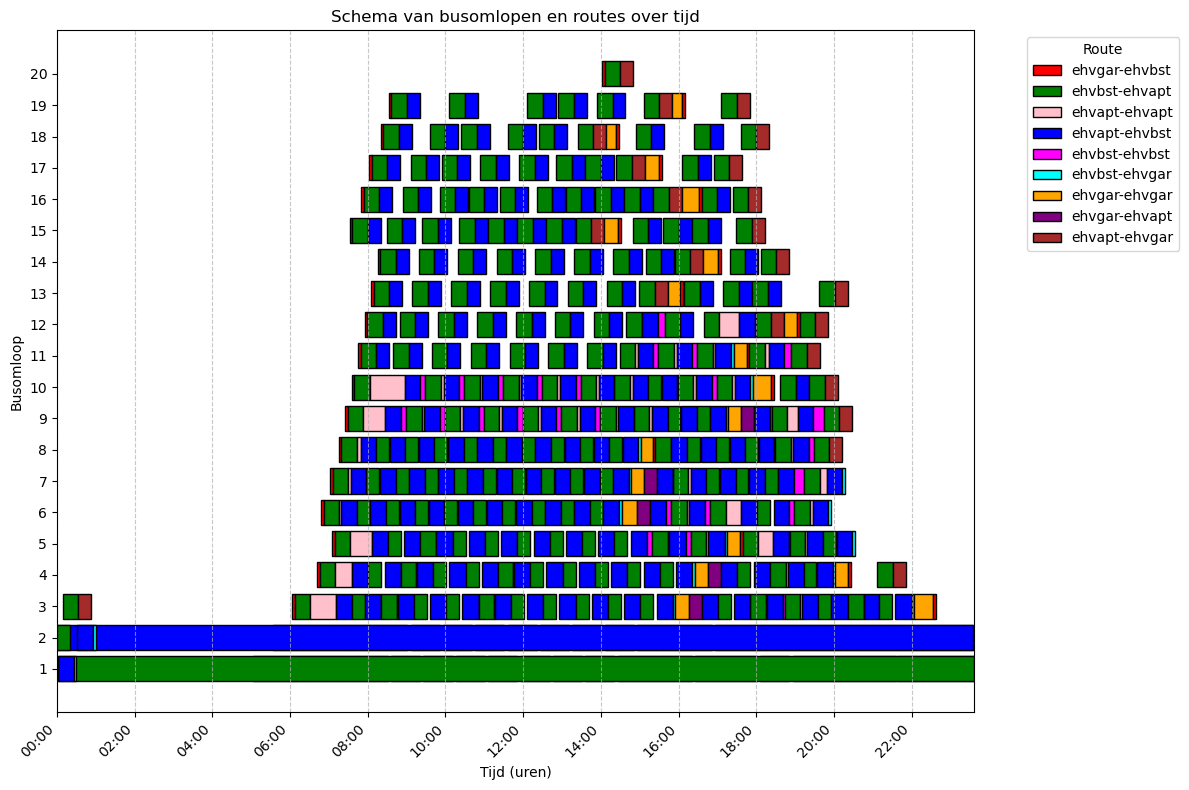

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

def plot_bus_schedule(df):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Houd bij welke routes al een label hebben om dubbele labels in de legenda te vermijden
    route_labels = {}
    
    # Itereer over de busomlopen
    for bus in df['omloop nummer'].unique():
        bus_df = df[df['omloop nummer'] == bus]
        for _, row in bus_df.iterrows():
            # Bereken de reistijd van de bus op de route
            reistijd = row['eindtijd'] - row['starttijd']
            
            # Voeg een balk toe voor de reistijd van de bus op de route
            if row['Route'] not in route_labels:
                ax.barh(bus, reistijd, left=row['starttijd'], color=row['Kleur'], edgecolor='black', label=row['Route'])
                route_labels[row['Route']] = True
            else:
                ax.barh(bus, reistijd, left=row['starttijd'], color=row['Kleur'], edgecolor='black')
    
    # Labels en opmaak
    ax.set_xlabel('Tijd (uren)')
    ax.set_ylabel('Busomloop')
    ax.set_title('Schema van busomlopen en routes over tijd')
    ax.set_yticks(df['omloop nummer'].unique())
    ax.set_yticklabels(df['omloop nummer'].unique())
    
    # Stel de limieten van de x-as in op basis van de vroegste starttijd en laatste eindtijd
    start_lim = df['starttijd'].min()
    end_lim = df['eindtijd'].max()
    ax.set_xlim([start_lim, end_lim])
    
    # Gebruik een formatter om tijd in uren en minuten weer te geven
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    # Stel de ticks op de x-as in om om de twee uur te weergeven
    ticks = pd.date_range(start=start_lim, end=end_lim, freq='2H')
    ax.set_xticks(ticks)
    
    # Voeg labels toe aan de ticks
    ax.set_xticklabels([tick.strftime('%H:%M') for tick in ticks], rotation=45, ha='right')

    # Voeg een legenda toe met de routes
    ax.legend(title="Route", bbox_to_anchor=(1.05, 1), loc='upper left')  # Plaats de legenda buiten de grafiek
    
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Voeg een grid toe voor betere leesbaarheid
    plt.tight_layout()  # Zorg dat alles netjes in beeld past
    plt.show()


df_planning['starttijd'] = pd.to_datetime(df_planning['starttijd'], format='%H:%M')
df_planning['eindtijd'] = pd.to_datetime(df_planning['eindtijd'], format='%H:%M')

# Plot het resultaat
plot_bus_schedule(df_planning)


mikkieeee


In [14]:
print('je moeder')

je moeder
